## Problem 2: Calculate and visualise the *dominance areas* of shopping centres (10 points)

In this problem, the aim is to delineate the dominance area of each shopping centre. For this 
exercise, we define the ‘dominance area’ of a shopping centre as the area from which it can 
be reached faster than other shopping centres. We will use public transport travel times.

![](images/dominance_areas_example_1000x500px.png)

*Sample result: a map showing the areas of dominance of each shopping centre, and the travel 
times to the closest shopping centre in the entire metropolitan area*



---

### Data

The **input data** is identical to what you have used for *problem 1*, 
see [there](./Exercise-4-problem-1.ipynb) for detailed data descriptions.

---


### An overview of the tasks

This task comprises of three major subtasks. In contrast to earlier exercises, we 
do not provide a detailed, step-by-step ‘cooking recipe’. Rather, you are free to
implement the necessary steps in any order you see fit, and choose any variable
names of your liking. 

To test intermediate results, implement `assert` statements, output the `head()`
of a data frame, or plot the data. Remember to add comments to all of your code,
so future you (and us) can understand what each section does.

The **only strict requirement** is the **file name** of
the **output** map plot: `DATA_DIRECTORY / "dominance_areas.png"`.

1. Load the YKR grid and the individual travel time data sets, and combine them 
   into one geo data frame. This is essentially the same as *problem 1*, except
   that you must load all eight shopping centre data files. (2 points)
2. Find the closest shopping centre to each grid cell. In the combined data set,
   find the minimum travel time to any of the shopping centres, save the value in
   a new column, and shopping centre name in another new column. (4 points)
   See the [hints](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-4/exercise-4.html#hints)
   to this exercise for a suggestions on how to achieve this 
   ([`pandas.DataFrame.min()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.min.html) and
   [`pandas.DataFrame.idxmin()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html)
   will be helpful)
3. Visualise the dominance areas and travel times. Use 2⨉1 subplots to plot
   the most dominant (closest) shopping centre for each grid cell, and the
   travel time to the closest shopping centre for each grid cell. (4 points)

---


In [45]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [46]:
import geopandas as gpd
import pandas as pd

# Read in the YKR grid to a geopandas dataframe
grid = gpd.read_file(DATA_DIRECTORY / "YKR_grid_EPSG3067.gpkg", driver='GPKG', geometry ='geometry')
grid.head()





/opt/miniconda3/envs/autogis/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(
/opt/miniconda3/envs/autogis/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GPKG does not support open option GEOMETRY
  return ogr_read(


,YKR_ID,geometry
0,5785640,"POLYGON ((382000 6697750, 381750 6697750, 3817..."
1,5785641,"POLYGON ((382250 6697750, 382000 6697750, 3820..."
2,5785642,"POLYGON ((382500 6697750, 382250 6697750, 3822..."
3,5785643,"POLYGON ((382750 6697750, 382500 6697750, 3825..."
4,5787544,"POLYGON ((381250 6697500, 381000 6697500, 3810..."


In [47]:
# Read in all the supermarket dataframes and merge with YKR
def load_supermarket_data(supermarkets, grid):
    merged_grids = {}
    for sm in supermarkets:
        for filepath in DATA_DIRECTORY.glob(f"travel_times_to_*_{sm}.txt"):
            df = pd.read_csv(filepath, delimiter=';')
            df = df.filter(['from_id', 'to_id', 'pt_r_t', 'car_r_t'])
            df = df.rename(columns=lambda col: f"{col}_{sm}")
            print(f"{filepath.name} loaded")
            merged_grid = grid.merge(df, how='inner', left_on='YKR_ID', right_on=f'from_id_{sm}')
            merged_grids[sm] = merged_grid
    return merged_grids


supermarkets = ['Itis', 'Myyrmanni', 'Jumbo', 'Dixi', 'Forum', 'Iso_Omena', 'Ruoholahti']
merged_grids = load_supermarket_data(supermarkets, grid)

for name, df in merged_grids.items():
    print(f"{name} dataframe has length {len(df)}")

travel_times_to_5944003_Itis.txt loaded
travel_times_to_5902043_Myyrmanni.txt loaded
travel_times_to_5878070_Jumbo.txt loaded
travel_times_to_5878087_Dixi.txt loaded
travel_times_to_5975373_Forum.txt loaded
travel_times_to_5978593_Iso_Omena.txt loaded
travel_times_to_5980260_Ruoholahti.txt loaded
Itis dataframe has length 13231
Myyrmanni dataframe has length 13231
Jumbo dataframe has length 13231
Dixi dataframe has length 13231
Forum dataframe has length 13231
Iso_Omena dataframe has length 13231
Ruoholahti dataframe has length 13231


In [48]:
# Merge all grids together
def merge_grids(base_df_name, grids):
    base_df = merged_grids[base_df_name]
    for df_name, df in grids.items():
        if df_name == base_df_name:
            pass
        else:
            df = df.drop(columns=[col for col in ['YKR_ID', 'geometry'] if col in df.columns])
            base_df = base_df.merge(
                df, 
                how='left', 
                left_on=f"from_id_{base_df_name}", 
                right_on=f'from_id_{df_name}'
            )
    return base_df

main_grid = merge_grids('Itis', merged_grids)
main_grid.head()

,YKR_ID,geometry,from_id_Itis,to_id_Itis,pt_r_t_Itis,car_r_t_Itis,from_id_Myyrmanni,to_id_Myyrmanni,pt_r_t_Myyrmanni,car_r_t_Myyrmanni,...,pt_r_t_Forum,car_r_t_Forum,from_id_Iso_Omena,to_id_Iso_Omena,pt_r_t_Iso_Omena,car_r_t_Iso_Omena,from_id_Ruoholahti,to_id_Ruoholahti,pt_r_t_Ruoholahti,car_r_t_Ruoholahti
0,5785640,"POLYGON ((382000 6697750, 381750 6697750, 3817...",5785640,5944003,132,50,5785640,5902043,90,39,...,110,49,5785640,5978593,141,56,5785640,5980260,118,56
1,5785641,"POLYGON ((382250 6697750, 382000 6697750, 3820...",5785641,5944003,135,51,5785641,5902043,93,39,...,113,49,5785641,5978593,143,56,5785641,5980260,121,56
2,5785642,"POLYGON ((382500 6697750, 382250 6697750, 3822...",5785642,5944003,137,58,5785642,5902043,95,47,...,115,57,5785642,5978593,145,64,5785642,5980260,123,63
3,5785643,"POLYGON ((382750 6697750, 382500 6697750, 3825...",5785643,5944003,141,57,5785643,5902043,99,51,...,119,60,5785643,5978593,149,67,5785643,5980260,127,67
4,5787544,"POLYGON ((381250 6697500, 381000 6697500, 3810...",5787544,5944003,125,50,5787544,5902043,83,38,...,103,48,5787544,5978593,134,55,5787544,5980260,111,55


In [49]:
# Drop unnecessary collumns for this exercise
main_grid = main_grid.drop(columns=[col for col in main_grid.columns if 'id' in col])
main_grid.head()

,YKR_ID,geometry,pt_r_t_Itis,car_r_t_Itis,pt_r_t_Myyrmanni,car_r_t_Myyrmanni,pt_r_t_Jumbo,car_r_t_Jumbo,pt_r_t_Dixi,car_r_t_Dixi,pt_r_t_Forum,car_r_t_Forum,pt_r_t_Iso_Omena,car_r_t_Iso_Omena,pt_r_t_Ruoholahti,car_r_t_Ruoholahti
0,5785640,"POLYGON ((382000 6697750, 381750 6697750, 3817...",132,50,90,39,101,39,102,45,110,49,141,56,118,56
1,5785641,"POLYGON ((382250 6697750, 382000 6697750, 3820...",135,51,93,39,108,39,109,45,113,49,143,56,121,56
2,5785642,"POLYGON ((382500 6697750, 382250 6697750, 3822...",137,58,95,47,109,45,111,52,115,57,145,64,123,63
3,5785643,"POLYGON ((382750 6697750, 382500 6697750, 3825...",141,57,99,51,114,46,115,48,119,60,149,67,127,67
4,5787544,"POLYGON ((381250 6697500, 381000 6697500, 3810...",125,50,83,38,98,38,99,44,103,48,134,55,111,55


In [50]:
len(merged_grids)

7

In [51]:
assert all(
    len(main_grid) == len(grid) 
    for grid in merged_grids.values()
           ), "Dataframe has changed in size - test join criteria"
assert all(
    sum(sm in col for col in main_grid.columns) == 2
    for sm in supermarkets
), "Not all supermarkets have 4 matching columns"

In [52]:
main_grid['min_time'] = main_grid.drop(columns=['YKR_ID', 'geometry'], axis=1).min(axis=1)
main_grid['min_time_sm'] = main_grid.drop(columns=['YKR_ID', 'geometry'], axis=1).idxmin(axis=1).apply(lambda x: x.split('_')[3])
main_grid.head()

,YKR_ID,geometry,pt_r_t_Itis,car_r_t_Itis,pt_r_t_Myyrmanni,car_r_t_Myyrmanni,pt_r_t_Jumbo,car_r_t_Jumbo,pt_r_t_Dixi,car_r_t_Dixi,pt_r_t_Forum,car_r_t_Forum,pt_r_t_Iso_Omena,car_r_t_Iso_Omena,pt_r_t_Ruoholahti,car_r_t_Ruoholahti,min_time,min_time_sm
0,5785640,"POLYGON ((382000 6697750, 381750 6697750, 3817...",132,50,90,39,101,39,102,45,110,49,141,56,118,56,39,Myyrmanni
1,5785641,"POLYGON ((382250 6697750, 382000 6697750, 3820...",135,51,93,39,108,39,109,45,113,49,143,56,121,56,39,Myyrmanni
2,5785642,"POLYGON ((382500 6697750, 382250 6697750, 3822...",137,58,95,47,109,45,111,52,115,57,145,64,123,63,45,Jumbo
3,5785643,"POLYGON ((382750 6697750, 382500 6697750, 3825...",141,57,99,51,114,46,115,48,119,60,149,67,127,67,46,Jumbo
4,5787544,"POLYGON ((381250 6697500, 381000 6697500, 3810...",125,50,83,38,98,38,99,44,103,48,134,55,111,55,38,Myyrmanni


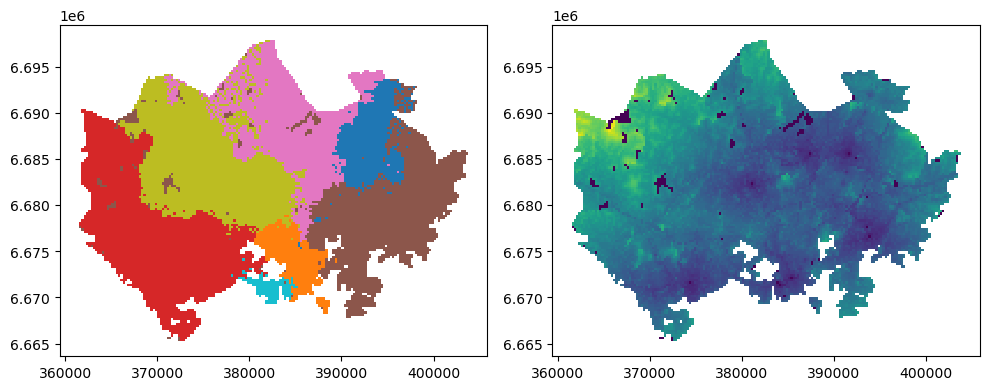

In [53]:
import matplotlib.pyplot as plt

# Prepare sub plots that are next to each other
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

main_grid.plot(ax=axes[0], column="min_time_sm")
axes[0].set_aspect(1)

main_grid.plot(ax=axes[1], column="min_time")
axes[1].set_aspect(1)

plt.savefig(DATA_DIRECTORY / "dominance_areas.png")
plt.tight_layout()
plt.show()

In [ ]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
assert (DATA_DIRECTORY / "dominance_areas.png").exists()


--- 

**Do not forget to plot the result map, and save it to `DATA_DIRECTORY / "dominance_areas.png"`!**

---

## Reflections

This was a significantly more complex exercise that previous ones, and it included finding
a solution yourself. 

- What was most difficult part? 
- Where did you get stuck? 
- What was the easiest, and
- what was the most fun part of this exercise?

Add your answer below


---

## Well done!

Congratulations, you completed exercise 4. Good Job!